In [1]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

### DataSource

In [2]:
class DataSource:
    
    def __init__(self, filename):
        self.df = pd.read_csv(filename)
    
    
    def data_load_split(self, target=None, ignore=None):
        self.target = target
        self.ignore = ignore
        self.inputs = sorted(set(self.df.columns) - set(self.target) - set(self.ignore))
        
        self.X = self.df[self.inputs]
        self.y = self.df[self.target]


    def define_problem(self):
        if self.y.dtypes[0] in ['int64', 'float64'] and self.y.nunique()[0] == 2:
            self.problem = "Binary"
        elif self.y.dtypes[0] in ['object', 'bool']:
            self.problem = "Classification"
        else:
            self.problem = "Regression"


    def train_val_split(self, ratio=0.2, random_state=42):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X, self.y,
                                                                              test_size=ratio,
                                                                              random_state=random_state)

    
    def data_preprocess(self, X, y, train_set=True):
        if train_set:
            # Data type detection
            numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
            categorical_ix = X.select_dtypes(include=['object', 'bool']).columns

            # Data transform
            num_transform = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])
            cat_transform = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value="Missing")),
                ('oh_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
            ])

            self.transform_x = ColumnTransformer(transformers=[
                ('num', num_transform, numerical_ix),
                ('cat', cat_transform, categorical_ix)
            ])
            self.trans_X_train = self.transform_x.fit_transform(X)
            
            if self.problem == "Classification":
                self.transform_y = ColumnTransformer(transformers=[
                    ('cat', cat_transform, y.columns)
                ])
            else:
                self.trans_y_train = y
        else:
            self.trans_X_val = self.transform_x.transform(X)
            if self.problem == "Classification":
                self.trans_y_val = self.transform_y.transform(y)
            else:
                self.trans_y_val = y

### MLP

In [107]:
keras.initializers.glorot_uniform(seed=42)

In [126]:
class MLP:
    
    def __init__(self, X, y, problem="Regression"):
        tf.random.set_seed(42)
        self.problem = problem
        self.X = X
        self.y = y


    def build_structure(self, max_hidden_layers=1, units=[16], use_all=False):
        self.structures = []
        self.structures_info = []
        if use_all:
            self.max_hidden_layers = 3
            self.units = [16, 32, 64, 128, 256]
        else:
            self.max_hidden_layers = max_hidden_layers
            self.units = units
    
        grid = [np.arange(self.max_hidden_layers)+1, self.units]
        for param_tuple in itertools.product(*grid):
            structure_param = {'hidden_layers': param_tuple[0],
                                'units': param_tuple[1]}

            # input layer
            model = keras.Sequential()
            model.add(keras.layers.Dense(16, input_shape=(self.X.shape[1],),
                                        kernel_initializer=keras.initializers.glorot_uniform(seed=42)))

            # hidden layer block
            for _ in range(structure_param['hidden_layers']):
                tf.random.set_seed(42)
                model.add(keras.layers.Dense(structure_param['units'], activation='relu',
                                            kernel_initializer=keras.initializers.glorot_uniform(seed=42)))

            # output layer
            if self.problem == 'Regression':
                model.add(keras.layers.Dense(1),
                         kernel_initializer=keras.initializers.glorot_uniform(seed=42))
            elif self.problem == 'Binary':
                model.add(keras.layers.Dense(1, activation='sigmoid',
                                            kernel_initializer=keras.initializers.glorot_uniform(seed=42)))
            else:
                model.add(keras.layers.Dense(self.y.shape[1], activation='softmax',
                                            kernel_initializer=keras.initializers.glorot_uniform(seed=42)))

            self.structures.append(model)
            self.structures_info.append(structure_param)

            
    def build_single_structure(self, hidden_layers=1, units=16):
        self.structures = []
        self.structures_info = []
        self.hidden_layers = hidden_layers
        self.units = units
        
        # input layer
        model = keras.Sequential()
        model.add(keras.layers.Dense(16, input_shape=(self.X.shape[1],),
                                    kernel_initializer=keras.initializers.glorot_uniform(seed=42)))
        
        # hidden layer
        for _ in range(hidden_layers):
            tf.random.set_seed(42)
            model.add(keras.layers.Dense(self.units, activation='relu',
                                        kernel_initializer=keras.initializers.glorot_uniform(seed=42)))
        
        # output layer
        if self.problem == 'Regression':
            model.add(keras.layers.Dense(1),
                      kernel_initializer=keras.initializers.glorot_uniform(seed=42))
        elif self.problem == 'Binary':
            model.add(keras.layers.Dense(1, activation='sigmoid',
                                        kernel_initializer=keras.initializers.glorot_uniform(seed=42)))
        else:
            model.add(keras.layers.Dense(self.y.shape[1], activation='softmax',
                                        kernel_initializer=keras.initializers.glorot_uniform(seed=42)))
            
        self.structures.append(model)
        self.structures_info.append({'hidden_layers': self.hidden_layers,
                                     'units': self.units})

        
    def create_optimizer(self, optimizers=['adam'], lrs=[0.01], use_all=False):
        self.created_optimizers = []
        self.optimizers_info = []
        self.optimizers = optimizers
        self.lrs = lrs

        self.optimizer_classes = {'adadelta': keras.optimizers.Adadelta, 'sgd': keras.optimizers.SGD,
                                  'adam': keras.optimizers.Adam, 'adagrad': keras.optimizers.Adagrad,
                                  'adamax': keras.optimizers.Adamax, 'rmsprop': keras.optimizers.RMSprop}

        if use_all:
            self.lrs = [0.001, 0.01, 0.02, 0.1]
            opt_grid = [self.optimizer_classes.keys(), self.lrs]    
        else:
            opt_grid = [self.optimizers, self.lrs]

        for opt_tuple in itertools.product(*opt_grid):
            opt_param = {
                'optimizer_name': opt_tuple[0],
                'lr': opt_tuple[1]
            }

            opt_class = self.optimizer_classes.get(opt_param['optimizer_name'])
            self.created_optimizers.append(opt_class(opt_param['lr']))
            self.optimizers_info.append(opt_param)

    
    def compile_model(self):
        if self.problem == "Regression":
            self.loss = keras.losses.MSE
            self.metrics = ['MSE', 'MAE']
        elif self.problem == "Binary":
            self.loss = keras.losses.binary_crossentropy
            self.metrics = ['accuracy']
        else:
            self.loss = keras.losses.categorical_crossentropy
            self.metrics = ['accuracy']

        self.compiled_models = []
        self.compiled_models_info = []

        compile_grid = [zip(self.structures, self.structures_info), zip(self.created_optimizers ,self.optimizers_info)]
        for compile_tuple in itertools.product(*compile_grid):
            compile_param = {'model': compile_tuple[0][0],
                             'optimizer': compile_tuple[1][0]}
            model_info = {'structure_info': compile_tuple[0][1],
                           'optimizer_info': compile_tuple[1][1]}

            model_body = compile_param['model']
            model = keras.models.clone_model(model_body)
            model.compile(optimizer=compile_param['optimizer'],
                               loss=self.loss,
                               metrics=self.metrics)

            self.compiled_models.append(model)
            self.compiled_models_info.append(model_info)

    
    def train_models(self, models, X_train, y_train, X_val=None, y_val=None,
                     batch_size=None, epochs=1, verbose=0, callbacks=None,
                     shuffle=True, steps_per_epoch=None):

        if callbacks:
            self.callbacks = callbacks
        else:
            self.callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=5, restore_best_weights=True)

        self.trained_models = []
        self.val_losses = []
        for model in models:
            model.fit(x=X_train, y=y_train,
                      batch_size=batch_size, epochs=epochs,
                      verbose=verbose, callbacks=callbacks,
                      validation_data=(X_val, y_val), shuffle=shuffle)
            
            val_loss = model.evaluate(X_val, y_val, verbose=0)
            self.trained_models.append(model)
            self.val_losses.append(val_loss[0])
            print("{} model is trained. best val loss is : {}".format(model.name, val_loss))
                
    
def select_best_model(trained_models, val_losses, models_info):
    best_idx = np.argmin(val_losses)
    best_model = trained_models[best_idx]
    best_model_info = models_info[best_idx]
    return best_model, best_model_info

## Titaninc

In [84]:
filename="./data/titanic_train.csv"
ds = DataSource(filename)

ds.data_load_split(target=['Survived'], 
                   ignore=["Name", "Cabin", "Ticket"])
ds.define_problem()
ds.train_val_split(ratio=0.2, random_state=42)
ds.data_preprocess(ds.X_train, ds.y_train, train_set=True)
ds.data_preprocess(ds.X_val, ds.y_val, train_set=False)

In [127]:
mlp = MLP(ds.trans_X_train, ds.trans_y_train, problem=ds.problem)
mlp.build_structure(max_hidden_layers=3, units=[16], use_all=False)
mlp.create_optimizer(optimizers=['adam'], lrs=[0.01], use_all=False)
mlp.compile_model()
mlp.train_models(mlp.compiled_models,
                 ds.trans_X_train, ds.trans_y_train, ds.trans_X_val, ds.trans_y_val,
                 batch_size=64, epochs=10)

sequential_142 model is trained. best val loss is : [0.8122628143855504, 0.8047619047619048]
sequential_143 model is trained. best val loss is : [0.8957998275756835, 0.7904761904761904]
sequential_144 model is trained. best val loss is : [1.1686970347449892, 0.7]


In [129]:
mlp1 = MLP(ds.trans_X_train, ds.trans_y_train, problem=ds.problem)
mlp1.build_single_structure(hidden_layers=2, units=16)
mlp1.create_optimizer(optimizers=['adam'], lrs=[0.01], use_all=False)
mlp1.compile_model()
mlp1.train_models(mlp1.compiled_models,
                  ds.trans_X_train, ds.trans_y_train, ds.trans_X_val, ds.trans_y_val,
                  batch_size=64, epochs=10)

sequential_146 model is trained. best val loss is : [0.7624824671518236, 0.8142857142857143]


In [62]:
mlp1.structures_info

[{'hidden_layers': 1, 'units': 16}]

In [15]:
trained_models

In [14]:
best_model, best_model_info = select_best_model(mlp.trained_models, mlp.val_losses, mlp.compiled_models_info)
best_model.evaluate(ds.trans_X_val, ds.trans_y_val)

7/7 [==============================] - 0s 2ms/step - loss: 0.4418 - accuracy: 0.8095


[0.4417726792040325, 0.8095238095238095]

In [15]:
best_model_info

{'structure_info': {'hidden_layers': 1, 'units': 128},
 'optimizer_info': {'optimizer_name': 'rmsprop', 'lr': 0.001}}

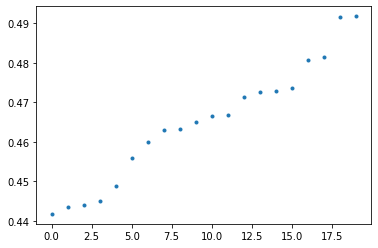

In [18]:
import matplotlib.pyplot as plt
plt.plot(sorted(mlp.val_losses)[:20], '.')

In [22]:
trained_models = mlp.train_models(mlp.compiled_models,
                                  ds.trans_X_train, ds.trans_y_train, ds.trans_X_val, ds.trans_y_val,
                                  batch_size=64, epochs=10)

sequential_15 model is trained. best val loss is : [0.6888229046549116, 0.6095238095238096]
sequential_15 model is trained. best val loss is : [0.6807561488378615, 0.4857142857142857]
sequential_15 model is trained. best val loss is : [0.6910825559071132, 0.5285714285714286]
sequential_15 model is trained. best val loss is : [0.5696458549726577, 0.7666666666666667]
sequential_15 model is trained. best val loss is : [0.6924643556276957, 0.5857142857142857]
sequential_15 model is trained. best val loss is : [0.5375234019188654, 0.780952380952381]
sequential_15 model is trained. best val loss is : [0.5121108872549874, 0.7952380952380952]
sequential_15 model is trained. best val loss is : [0.48063602362360275, 0.7857142857142857]
sequential_15 model is trained. best val loss is : [0.4996756962367466, 0.8095238095238095]
sequential_15 model is trained. best val loss is : [0.9988024155298869, 0.8333333333333334]
sequential_15 model is trained. best val loss is : [1.3103821073259627, 0.819047

sequential_18 model is trained. best val loss is : [0.830685559908549, 0.8]
sequential_18 model is trained. best val loss is : [1.4101232131322226, 0.8047619047619048]
sequential_18 model is trained. best val loss is : [0.5200128078460693, 0.7714285714285715]
sequential_18 model is trained. best val loss is : [1.1736657051813035, 0.8047619047619048]
sequential_18 model is trained. best val loss is : [1.535784555616833, 0.819047619047619]
sequential_18 model is trained. best val loss is : [3.017766114643642, 0.780952380952381]
sequential_19 model is trained. best val loss is : [0.6943417798905146, 0.49047619047619045]
sequential_19 model is trained. best val loss is : [0.6826193991161528, 0.6428571428571429]
sequential_19 model is trained. best val loss is : [0.6617516182717823, 0.7095238095238096]
sequential_19 model is trained. best val loss is : [0.5192547457558768, 0.7904761904761904]
sequential_19 model is trained. best val loss is : [0.688214019366673, 0.5857142857142857]
sequenti

sequential_22 model is trained. best val loss is : [0.5049135645230611, 0.7523809523809524]
sequential_22 model is trained. best val loss is : [0.4779707321098873, 0.7857142857142857]
sequential_22 model is trained. best val loss is : [0.5760446889059884, 0.7666666666666667]
sequential_22 model is trained. best val loss is : [0.4725632993947892, 0.7904761904761904]
sequential_22 model is trained. best val loss is : [0.8260151885804676, 0.8047619047619048]
sequential_22 model is trained. best val loss is : [1.0292031458445958, 0.8047619047619048]
sequential_22 model is trained. best val loss is : [1.6832849161965506, 0.8]
sequential_22 model is trained. best val loss is : [0.622218956833794, 0.7666666666666667]
sequential_22 model is trained. best val loss is : [1.3273283050173805, 0.7666666666666667]
sequential_22 model is trained. best val loss is : [1.1840834572201684, 0.7857142857142857]
sequential_22 model is trained. best val loss is : [2.8000212260654993, 0.7142857142857143]
sequ

sequential_26 model is trained. best val loss is : [0.7504922395660764, 0.8285714285714286]
sequential_26 model is trained. best val loss is : [2.2662139551980154, 0.8047619047619048]
sequential_26 model is trained. best val loss is : [4.108737527756464, 0.7904761904761904]
sequential_26 model is trained. best val loss is : [0.6725161223184495, 0.6047619047619047]
sequential_26 model is trained. best val loss is : [0.6781520712943304, 0.6]
sequential_26 model is trained. best val loss is : [0.5202922934577578, 0.7857142857142857]
sequential_26 model is trained. best val loss is : [0.503912547656468, 0.7619047619047619]
sequential_26 model is trained. best val loss is : [0.5377610195250738, 0.8047619047619048]
sequential_26 model is trained. best val loss is : [0.49744862828935893, 0.7761904761904762]
sequential_26 model is trained. best val loss is : [0.7990169780594962, 0.8047619047619048]
sequential_26 model is trained. best val loss is : [0.8531070680845352, 0.8142857142857143]
sequ

In [23]:
best_model, best_model_info = select_best_model(mlp.trained_models, mlp.val_losses, mlp.compiled_models_info)
best_model.evaluate(ds.trans_X_val, ds.trans_y_val)

7/7 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.7905


[0.4454500885236831, 0.7904761904761904]

In [24]:
best_model_info

{'structure_info': {'hidden_layers': 1, 'units': 16},
 'optimizer_info': {'optimizer_name': 'rmsprop', 'lr': 0.001}}